# Final Project (Sentiment Analysis ML Model)
### By: Yuan-Cheng (Hayden) Tsai
#### Data:  Disneyland Reviews: Reviews and Ratings of 3 Disneyland branches - California, Hong Kong and Paris 
#### Source: https://www.kaggle.com/datasets/arushchillar/disneyland-reviews

## Imports and Data Checks

In [201]:
import re, random, os

import numpy as np
import pandas as pd

from matplotlib import style
import plotly.graph_objs as go
import plotly.io as pio
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re 
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
stopWords_nltk = set(stopwords.words('english'))

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 10
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

In [202]:
#Import Data
df = pd.read_csv("DisneylandReviews.csv")
df.drop(['Review_ID', 'Year_Month', 'Reviewer_Location'], axis=1, inplace=True)
df.rename(columns={'Rating': 'Rating', 'Review_Text': 'Review'}, inplace=True)
df = df.iloc[:10000,:]
df.head()

,Rating,Review,Branch
0,4,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the ...,Disneyland_HongKong
1,4,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomo...",Disneyland_HongKong
2,4,Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be...,Disneyland_HongKong
3,4,HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work go...,Disneyland_HongKong
4,4,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much...",Disneyland_HongKong


In [203]:
#Calculating dimensions
print('Dimensions: ')
print(df.shape)
print()
#Checking info
print('Info: ')
print(df.info())

Dimensions: 
(10000, 3)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  10000 non-null  int64 
 1   Review  10000 non-null  object
 2   Branch  10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB
None


## Text Preprocessing

In [204]:
# Remove duplicate values
df.drop_duplicates(keep=False, inplace=True)

# Remove punctuation
from textacy.preprocessing.remove import punctuation
df['Review'] = df['Review'].apply(punctuation)

# Convert to lowercase 
df['Review'] = df['Review'].map(lambda x: x.lower())

# Replace common entities
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
df['Review'] = df['Review'].\
 apply(urls).\
 apply(hashtags).\
 apply(currency_symbols).\
 apply(emojis).\
 apply(emails)

#Define and remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))

# Clean out Disney location references and ride references
df['Review'] = df['Review'].str.replace(r"disney(?:land| park)?|park|place|hong kong|hk|cali|california|paris|pa|fr|Disneyland Railroad|\
                            Great Moments with Mr. Lincoln | Lincoln| The Disney Gallery | Gallery| Main Street Vehicles | \
                            Main Street Cinema | Main Street | Walt Disney's Enchanted Tiki Room | Enchanted Tiki Room | Jungle Cruise | \
                            Indiana Jones | Pirates of the Caribbean | Haunted Mansion | \
                            Davy Crockett Explorer Canoes | Davy Crockett | Explorer Canoes | Many Adventures of Winnie the Pooh | Winnie the Pooh | Splash Mountain | \
                            Big Thunder Mountain Railroad | Mark Twain Riverboat | Mark Twain | Frontierland Shootin Exposition |Frontierland| \
                            Pirate's Lair on Tom Sawyer Island | Pirate's Lair | Tom Sawyer | Sailing Ship Columbia | \
                            Mickey's House | Meet Mickey | Minnie's House | Roger Rabbit's Car Toon Spin | Roger Rabbit | \
                            Chip 'n' Dale's Gadget Coaster | Gadget Coaster | Fantasyland Theatre | It's a Small World | Small World | \
                            Mr. Toad's Wild Ride | Peter Pan's Flight | Pinocchio's Daring Journey | Pixie Hollow |\
                            Snow White's Enchanted Wish | Snow White | Enchanted Wish | Storybook Land Canal Boats | Storybook Land| Canal Boats |Dumbo the Flying Elephant | Dumbo |\
                            Casey Jr. Circus Train | Circus Train | Alice in Wonderland | Matterhorn Bobsleds | Bobsleds | King Arthur Carrousel | King Arthur |\
                            Mad Tea Party | Sleeping Beauty Castle Walkthrough | Sleeping Beauty| Astro Orbiter | \
                            Autopia Star Tours – The Adventures Continue | Autopia Star Tours | Buzz Lightyear Astro Blasters | Buzz Lightyear | Astro Blasters |\
                            Space Mountain | Monorail | Finding Nemo Submarine Voyage | Finding Nemo | Submarine Voyage |\
                            Star Wars Launch Bay | Star Wars | Millennium Falcon: Smuggler's Run | Millennium Falcon | Smuggler's Run| Rise of the Resistance | \
                            Electrical Parade | Galaxy's Edge | Tomorrowland | Fantasyland | \
                            Mickey's Toontown | Toontown | Frontierland | Critter Country | New Orleans Square | Adventureland | \
                            Main Street, U.S.A.| toy story | lion king | main street | small world | sce mountain | \
                            story land | king show | mickey mouse | grizzly gulch | mystic manor | \
                            big thunder mountain | chinese new year | slinky dog ride | jungle river cruise | lion king show | \
                            toy story| festival lion king | runaway mine cars | mine cars | iron man |\
                            big grizzly mountain | sunny bay station | small world | mountain runaway mine | \
                            iron man experience | sleeping beauty castle | sce mountain | buzz light year | \
                            big thunder | iron man experience | mickey | minnie | \
                            big grizzley | buzz lightyear | mountain",'')

# Drop words with less than 5 frequencies
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts()
drops = temp_df[temp_df <= 5]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))



#Regex (parse out and normalize all references to people)
PERSON_PATTERN: re.Pattern = re.compile(r"\b(?:Great-grandfather'?s?\b|Great-grandmother'?s?\b|Great-uncle'?s?\b|\
                                        Grandfather'?s?\b|Grandmother'?s?\b|Great-aunt'?s?\b|Uncle|Aunt'?s?\b|Father'?s?\b|\
                                        Mother'?s?\b|Uncle'?s?\b|Sister'?s?\b|Brother-in-law'?s?\b|Brother'?s?\b|\
                                        Sister-in-law'?s?\b|Husband'?s?\b|Wife'?s?\b|Cousin'?s?\b|Cousins wife'?s?\b|\
                                        Cousin'?s?\b|Cousin'?s?\b husband'?s?\b|Nephew'?s?\b|Niece'?s?\b|Son'?s?\b|\
                                        Daughter-in-law'?s?\b|Daughter'?s?\b|Son-in-law'?s?\b|First cousin once removed'?s?\b|\
                                        grandson'?s?\b|grandson'?s?\b|grand\sson'?s?\b|grand\sdaughter'?s?\b|Granddaughter'?s?\b|Baby'?s?\b|Child'?s?\b|Infants'?s?\b|Newborn'?s?\b|\
                                        Mom'?s?\b|Dad'?s?\b|\d{0,3}\s?years?\sold'?s?\b|\d{0,3}\s?month'?s?\sold'?s?\b|\
                                        \d{0,3}\s?yr'?s?\sold'?s?\b|kid|kids|yr old|year old|u|pa|Mom'?s?\b|Dad'?s?\b|honey'?s?\b|\
                                        hubby'?s?\b|papa'?s?\b|mama'?s?\b|gram'?s?\b|gramp'?s?\b)\b", flags=re.IGNORECASE)
result = []
for value in df["Review"]:
    result.append(re.sub(PERSON_PATTERN, '_PERSON_', value))
df["Reviews"] = result 
df = df.drop('Review', axis=1)

## Visualizations

### Wordcloud

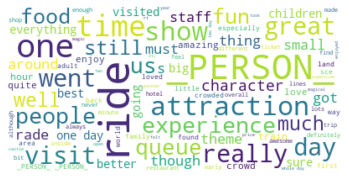

In [205]:
#Wordcloud graph
text = " ".join(i for i in df.Reviews) 
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

### Histogram of Ratings

In [206]:
#Histogram of Ratings
fig = px.histogram(df,
             x = 'Rating',
             title = 'Histogram of Review Rating',
             template = 'ggplot2',
             color = 'Rating',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )
fig.update_yaxes(title='Count')
fig.show();

### Target Count

In [207]:
#Target Count
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2
    
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

# encode label and mapping label name
df["label"] = df["Rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen']
fig.add_trace(go.Pie(labels=df.label_name.value_counts().index,
                             values=df.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=df.label_name.value_counts().index, y=df.label.value_counts().values, marker_color = colors), 1,2)

fig.show();

### Token Counts with simple tokenizer

In [208]:
def tokenize(text):
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized
# tokenize data
df["tokenized_review"] = df.Reviews.apply(lambda x: tokenize(x))
# calculate token count
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show();

In [209]:
(df.sent_token_length < 512).mean()

0.9997994786444756

### Token Counts with BERT tokenizer

In [210]:
#!pip install transformers

In [211]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
# tokenize data with bert tokenizer
df["sent_bert_token_length"] = df["Reviews"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show();

Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


In [212]:
# Less than 512 covers how much of the data
(df.sent_bert_token_length < 512).mean()

0.9994986966111891

### Characters Count in the Data

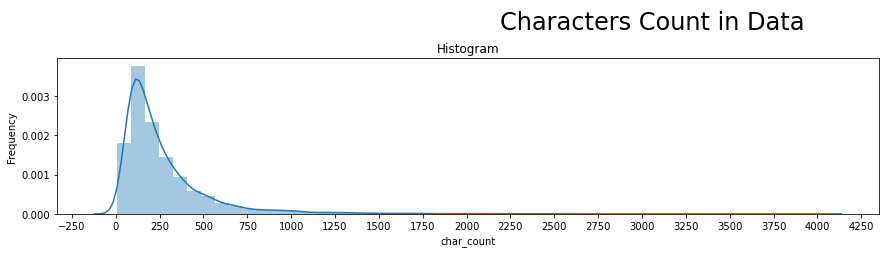

In [213]:
# Calvulate character count for each review
df['char_count'] = df['Reviews'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)
plot_dist3(df, 'char_count',
           'Characters Count in Data')

### Reviews Lengths

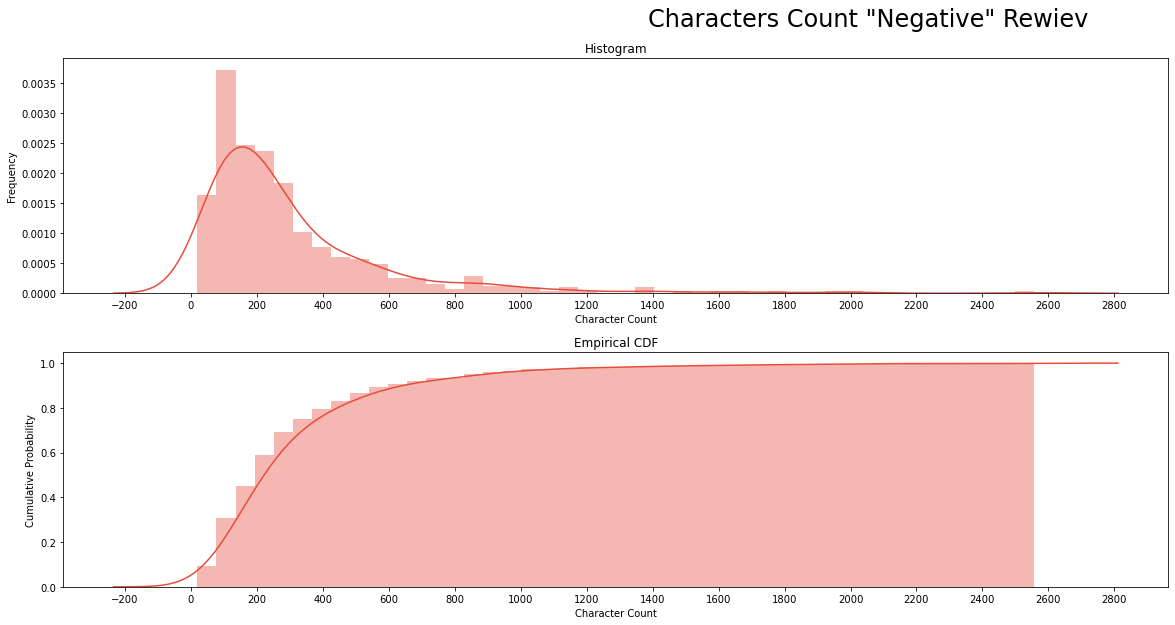

In [214]:
# Creating a new feature for the visualization.
df['Character Count'] = df['Reviews'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Empirical CDF')
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')
    plt.suptitle(f'{title}', fontsize=24)
    
plot_dist3(df[df['label'] == 0], 'Character Count',
           'Characters Count "Negative" Rewiev')

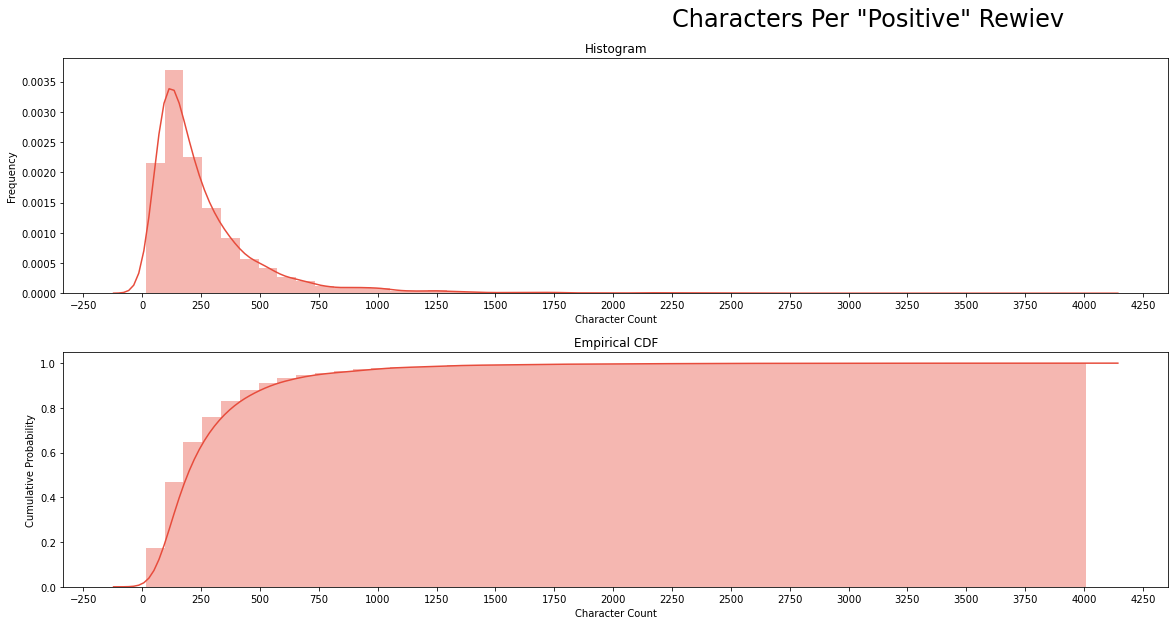

In [215]:
plot_dist3(df[df['label'] == 2], 'Character Count',
           'Characters Per "Positive" Rewiev')

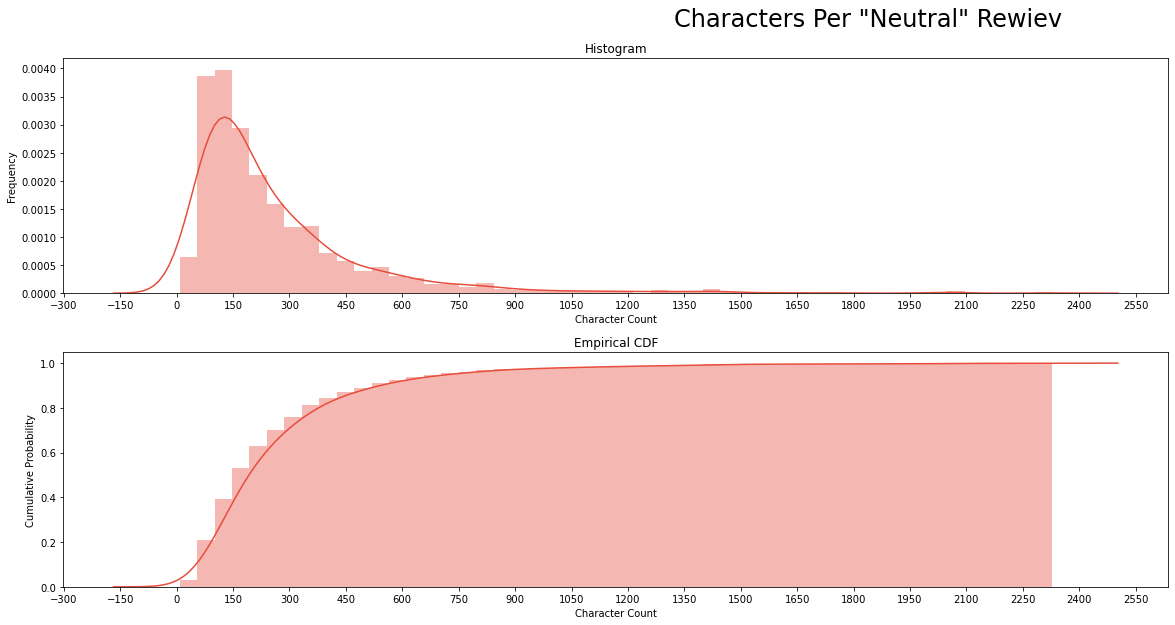

In [216]:
plot_dist3(df[df['label'] == 1], 'Character Count',
           'Characters Per "Neutral" Rewiev')

### Word Counts

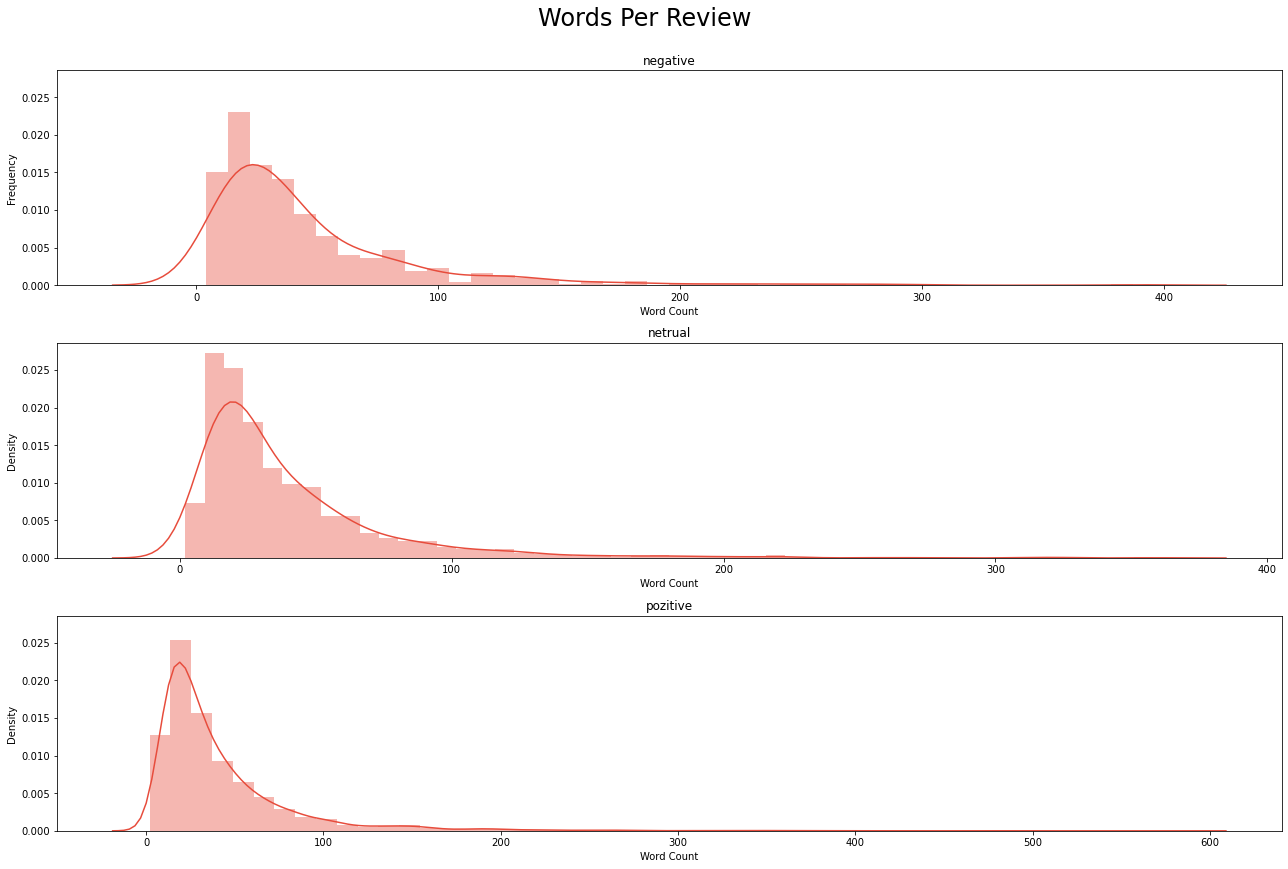

In [217]:
#comparing word counts
def plot_word_number_histogram(textno, textye, textz):

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('negative')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('netrual')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('pozitive')
    
    fig.suptitle('Words Per Review', fontsize=24, va='baseline')
    
    fig.tight_layout()
    
plot_word_number_histogram(df[df['label'] == 0]['Reviews'],
                           df[df['label'] == 1]['Reviews'],
                           df[df['label'] == 2]['Reviews'],
                          )

### Most Common Words

In [218]:
texts = df['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show();

### Most Common ngrams

In [219]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show();

In [220]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [221]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))      
fig.show();

In [222]:
#trigram

fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
    
fig.show();

### Encoding target variable-sentiment

In [223]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in sentiment column
df['label']= label_encoder.fit_transform(df['label']) 
df['label'].unique() 

array([2, 1, 0], dtype=int64)

In [224]:
df['label'].value_counts()

2    8041
1    1392
0     541
Name: label, dtype: int64

### TFIDF(Term Frequency — Inverse Document Frequency)

In [225]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(df['Reviews'])

In [226]:
X.shape

(9974, 5000)

In [227]:
#Get the target variable (encoded)
y=df['label']

### Handling Imbalance target feature-SMOTE

In [228]:
#pip install -U imbalanced-learn

In [229]:
#pip install threadpoolctl==3.1.0

In [230]:
from imblearn.over_sampling import SMOTE
print(f'Original dataset shape : {Counter(y)}')

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 8041, 1: 1392, 0: 541})
Resampled dataset shape Counter({2: 8041, 1: 8041, 0: 8041})


### Train-test split(75:25)

In [231]:
from sklearn.model_selection import train_test_split
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

### Model Building: Sentiment Analysis

In [232]:
#Create Objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]

for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8127136921787408
Decision Tree Test Accuracy: 0.7351137581079914
KNN Test Accuracy: 0.805895341334625
SVC Test Accuracy: 0.8078002544708273
Naive Bayes Test Accuracy: 0.7675915522117455


### Logistic Regression with Hyperparameter tuning

In [233]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.9174266290830708


In [234]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

LogisticRegression(C=10000.0, random_state=0)

Accuracy of logistic regression classifier on test set: 0.92


### Classification metrics

In [235]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


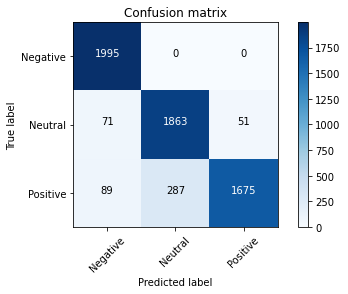

In [236]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [237]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1995
           1       0.87      0.94      0.90      1985
           2       0.97      0.82      0.89      2051

    accuracy                           0.92      6031
   macro avg       0.92      0.92      0.92      6031
weighted avg       0.92      0.92      0.92      6031



### ROC-AUC curve

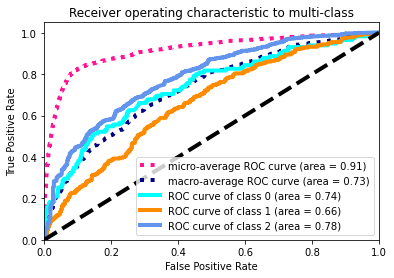

In [238]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show();